In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from pandas.plotting import scatter_matrix

from sklearn.metrics import accuracy_score, classification_report, auc
from sklearn.metrics import plot_confusion_matrix
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

%matplotlib inline

# Particle ID Using Random Boosted Decision Trees

In this example, we're going to be using decision trees to analyze simulated data from particle detectors.  The particles traverse the detector, depositing energy via ionization and radiation as they go.  The detector response to this energy deposition is recorded and can be used to infer what type of particle deposited the energy.

We should be able to do a very effective job of classifying particles by dividing the data into distinct final states via the use of boosted decision trees.  Our challenge in this part of the problem is to get a feeling for how a "normal" decision tree can tend to overtrain and how to combat that tendency to overtrain.

This data sample has 500 thousand entries, each of which has seven variables:

1. "id": This is the PDG (Particle Data Group) particle id.  The number corresponds to particle type and the sign gives the charge (particles that can have charge magnitude greater than 1 are handled differently): -11 = electron, 211 = pion, 321 = kaon, 2212 = proton.
2. "p": The particle's measured momentum.
3. "theta": The polar angle of the particle's momentum vector relative to the incoming beam axis.
4. "beta": The particle's velocity divided by the speed of light (aka, p/E)
5. "nphe": The number of photo electrons collected in one part of the detector apparatus.
6. "ein": The energy deposited in the inner calorimeter detector.
7. "eout": The energy deposited in the outer calorimeter detector.

In some cases, these variables are zero.  This can either mean that the actual value was zero, but it can also mean that the detector did not record a value due to inefficiency.  You should also expect that the data itself has noise coming from various sources.  This makes accurate particle identification a challenge, but likely not an insurmountable one!

***
***
# Read the data file and organize our data

The data is stored in a CSV file, which we're not quite good at extracting.

In [2]:
nExamples = 100000
datasetTrain = pd.read_csv("particleID/train.csv",nrows=nExamples)
datasetTest = pd.read_csv("particleID/test.csv",nrows=nExamples)

print("Header: ", datasetTrain.head(5))
print("\nDescription: ", datasetTrain.describe())

# class distribution
print("\nClass description: ", datasetTrain.groupby('id').size())

Header:       id         p     theta      beta  nphe       ein      eout
0   211  0.780041  1.081480  0.989962     0  0.000000  0.000000
1   211  0.260929  0.778892  0.902450     0  0.000000  0.000000
2  2212  0.773022  0.185953  0.642428     4  0.101900  0.000000
3   211  0.476997  0.445561  0.951471     0  0.000000  0.000000
4  2212  2.123290  0.337332  0.908652     0  0.034379  0.049256

Description:                    id              p          theta           beta  \
count  100000.000000  100000.000000  100000.000000  100000.000000   
mean      992.069800       1.231136       0.488721       0.899760   
std       971.914274       0.742582       0.294064       0.113260   
min       -11.000000       0.210117       0.093336       0.550041   
25%       211.000000       0.666056       0.281363       0.837612   
50%       211.000000       1.066450       0.404475       0.946710   
75%      2212.000000       1.655450       0.611951       0.985656   
max      2212.000000       5.028150     

***
***
# Massage data to obtain testing and training arrays

We'll drop some variables and create some indexing arrays to allow us to select out certain types of particles.

In [3]:
X = datasetTrain.drop(['id','theta','nphe','ein','eout'],axis=1,inplace=False)
X_train = X.values

X = datasetTest.drop(['id','theta','nphe','ein','eout'],axis=1,inplace=False)
X_test = X.values

# Two forms of the 
y = pd.get_dummies(datasetTrain.id)

y_train = y.values[:,2]
elecIdx = np.array(y.values[:,0]==1)
pionIdx = np.array(y.values[:,1]==1)
kaonIdx = np.array(y.values[:,2]==1)
protIdx = np.array(y.values[:,3]==1)

y = pd.get_dummies(datasetTest.id)
y_test = y.values[:,2]

elecIdxTest = np.array(y.values[:,0]==1)
pionIdxTest = np.array(y.values[:,1]==1)
kaonIdxTest = np.array(y.values[:,2]==1)
protIdxTest = np.array(y.values[:,3]==1)

***
***
# Create and train a decision tree

The `scikit-learn` decision tree is both well documented and very fast to train!  Let's start with some of the basic parameters:

1. max_depth = the maximum depth allowed for the tree
2. min_samples_split = the minimum number of examples that collect in a node before it can be split
3. min_samples_leaf = the minimum number of examples in a node to allow it to become a terminal node
4. max_leaf_nodes = the overall maximum number of leaf nodes to allow
5. class_weights = weights to apply to each class in case the number of examples is not uniform over classes

In [4]:
maxDepth = 4
minSS = 2  #Minimum samples required to allow a node split
minSL = 1  #Minimum samples required for a leaf (terminal node)
maxLeaf = None #Maximum number of leaves in the tree
cWeights = {0:1, 1:19}

dTree = DecisionTreeClassifier(random_state=1,
                               max_depth=maxDepth,
                               min_samples_split=minSS,
                               min_samples_leaf=minSL, 
                               max_leaf_nodes=maxLeaf,
                               class_weight=cWeights)
dTree.fit(X_train, y_train)

print(dTree.get_depth())
print(dTree.get_n_leaves())

4
16


***
***
# Calculate and report the accuracy of this trained tree

Training Dataset: 
Total Accuracy:  0.83232
Kaon Accuracy:  0.7938428874734608
Pion Accuracy:  0.7834950592005697
Proton Accuracy:  0.906364339087864

Testing Dataset: 
Total Accuracy:  0.83418
Kaon Accuracy:  0.7985689505637468
Pion Accuracy:  0.7861440942772967
Proton Accuracy:  0.9061525085664603


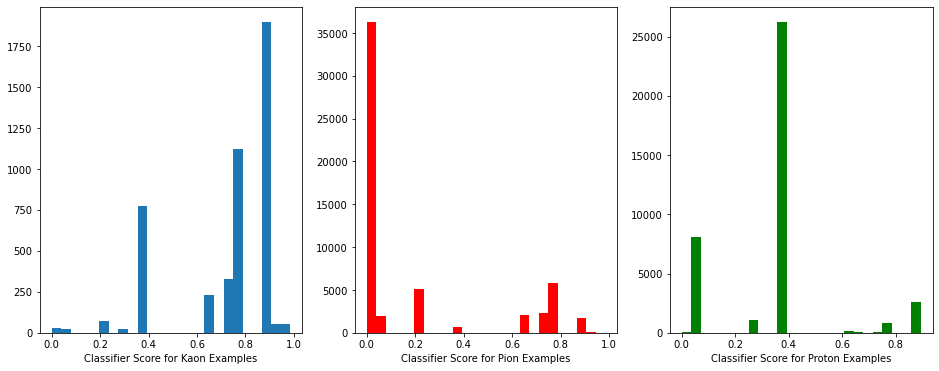

Maximum Purity:  0.7638782794683406
ROC AOC:  0.8845379098688949


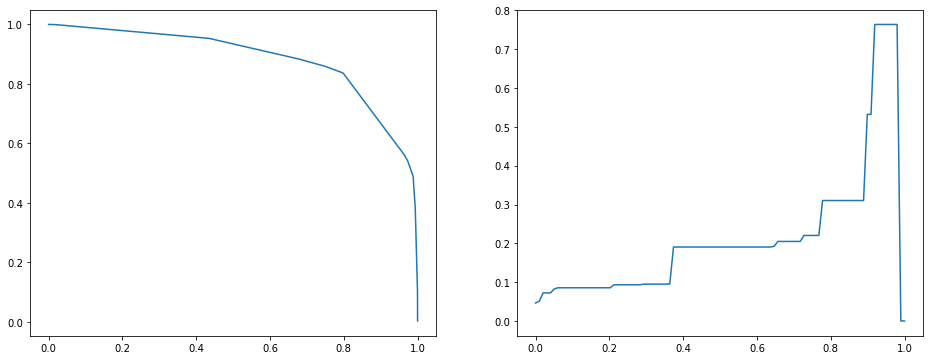

In [12]:
def calcROC(clf):
    predictions = clf.predict_proba(X_test)[:,1]
    bins = 100
    xvals = np.linspace(0,1,bins)
    purity = np.linspace(0,1,bins)
    rocX = np.linspace(0,1,bins)
    rocY = np.linspace(0,1,bins)
    maxPurity = 0
    totSig = np.count_nonzero(predictions[kaonIdxTest]>=0)
    totBkg = np.count_nonzero(predictions>=0)-totSig

          
    for idx, val in enumerate(xvals):
        sig = np.count_nonzero(predictions[kaonIdxTest]>=val)
        bkgdPi = np.count_nonzero(predictions[pionIdxTest]>=val)
        bkgdPr = np.count_nonzero(predictions[protIdxTest]>=val)
        purity[idx] = sig / (sig+bkgdPi+bkgdPr+1e-3)
        
        if sig / (sig+bkgdPi+bkgdPr+1e-3) > maxPurity:
            maxPurity = sig / (sig+bkgdPi+bkgdPr+1e-3)
        
        rocX[idx] = 1.0*sig/totSig
        rocY[idx] = 1-1.0*(bkgdPi+bkgdPr)/totBkg
    
    print("Maximum Purity: ", maxPurity)
    print("ROC AOC: ", auc(rocX,rocY))
    
    fig, ax = plt.subplots(1,2,figsize=(16,6))
    ax[0].plot(rocX,rocY)
    ax[1].plot(xvals,purity)
    plt.show()    

    
def evalClassifier(clf):
    predictionsBinary = clf.predict(X_train)

    print("Training Dataset: ")
    print("Total Accuracy: ",accuracy_score(y_train,predictionsBinary))
    print("Kaon Accuracy: ",accuracy_score(y_train[kaonIdx],predictionsBinary[kaonIdx]))
    print("Pion Accuracy: ",accuracy_score(y_train[pionIdx],predictionsBinary[pionIdx]))
    print("Proton Accuracy: ",accuracy_score(y_train[protIdx],predictionsBinary[protIdx]))

    predictions = clf.predict_proba(X_test)
    predictionsBinary = clf.predict(X_test)

    print("\nTesting Dataset: ")
    print("Total Accuracy: ",accuracy_score(y_test,predictionsBinary))
    print("Kaon Accuracy: ",accuracy_score(y_test[kaonIdxTest],predictionsBinary[kaonIdxTest]))
    print("Pion Accuracy: ",accuracy_score(y_test[pionIdxTest],predictionsBinary[pionIdxTest]))
    print("Proton Accuracy: ",accuracy_score(y_test[protIdxTest],predictionsBinary[protIdxTest]))

    fig, ax = plt.subplots(1,3,figsize=(16,6))
    ax[0].hist(predictions[kaonIdxTest][:,1],bins=25)
    ax[0].set_xlabel("Classifier Score for Kaon Examples")
    ax[1].hist(predictions[pionIdxTest][:,1],bins=25,color='r')
    ax[1].set_xlabel("Classifier Score for Pion Examples")
    ax[2].hist(predictions[protIdxTest][:,1],bins=25,color='g')
    ax[2].set_xlabel("Classifier Score for Proton Examples")

    plt.show()
    
    calcROC(clf)
    
evalClassifier(dTree)

# Create and train a random forest of decision trees

Fortunately, the parameters that control the architecture of the trees in the forest are mostly the same as with the simple decision tree.  However, we add three important parameters to configure the random forest:

1. n_estimators : This is the number of trees to include in the random forest.
2. bootstrap : Boolean argument to turn on/off the use of bootstrap data samples for training.
3. max_samples: If using boostrap samples, the randomly-drawn fraction of the total to be included in each bootstrap sample.

Training Dataset: 
Total Accuracy:  0.88672
Kaon Accuracy:  0.9660297239915074
Pion Accuracy:  0.8619959049229947
Proton Accuracy:  0.9120587477454264

Testing Dataset: 
Total Accuracy:  0.88833
Kaon Accuracy:  0.9611882046834345
Pion Accuracy:  0.8648692081064191
Proton Accuracy:  0.912698818595612


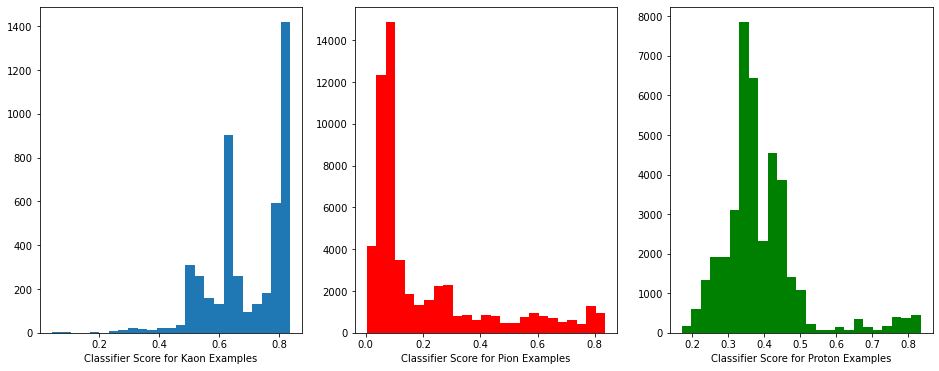

Maximum Purity:  0.5704337905499295
ROC AOC:  0.9443286845971051


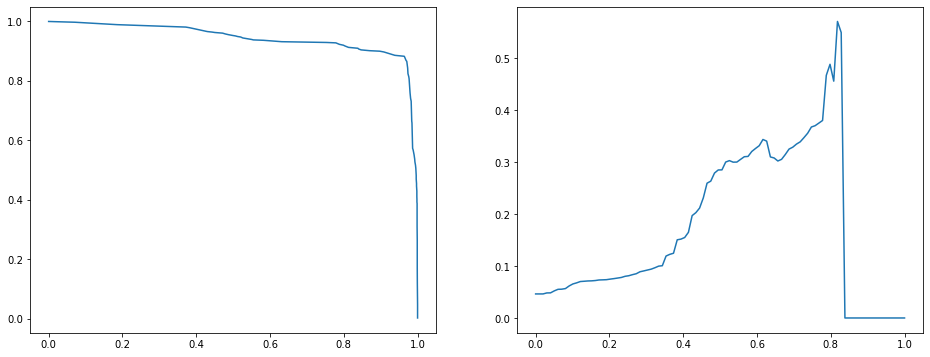

In [13]:
randForest = RandomForestClassifier(random_state=1,
                                    n_estimators=20, 
                                    bootstrap = True,
                                    max_samples = 0.8,
                                    max_depth=maxDepth,
                                    min_samples_split=minSS,
                                    min_samples_leaf=minSL, 
                                    max_leaf_nodes=maxLeaf,
                                    class_weight=cWeights)

randForest.fit(X_train,y_train)

evalClassifier(randForest)

# Create and train a boosted decision tree

In [7]:
# Unfortunately the gradient boosting classifier doesn't allow us to 
# input our class weights as we did with the random forest and the
# vanilla DT.  However, we can use sample weights in the .fit() method.
# This isn't quite as good as training with the weights, but we can
# use our own accuracy metrics to decide which configuration works best

sWeight = kaonIdx * 18.0 + 1.0 # 1 for class 0, 19 for class 1
print(np.max(sWeight))

[False False False ... False False False]
19.0


Testing  30 0.07
Kaon Accuracy:  0.9616218560277537
Testing  30 0.07500000000000001
Kaon Accuracy:  0.9635732870771899
Testing  30 0.08000000000000002
Kaon Accuracy:  0.9594535993061578
Testing  30 0.08500000000000002
Kaon Accuracy:  0.9596704249783174
Testing  30 0.09000000000000002
Kaon Accuracy:  0.9635732870771899
Testing  30 0.09500000000000003
Kaon Accuracy:  0.959887250650477
Testing  30 0.10000000000000003
Kaon Accuracy:  0.9618386816999133
Training Dataset: 
Total Accuracy:  0.91017
Kaon Accuracy:  0.9713375796178344
Pion Accuracy:  0.8908751001513397
Proton Accuracy:  0.929966503478485

Testing Dataset: 
Total Accuracy:  0.91036
Kaon Accuracy:  0.9618386816999133
Pion Accuracy:  0.8920632086420855
Proton Accuracy:  0.9299851685163402


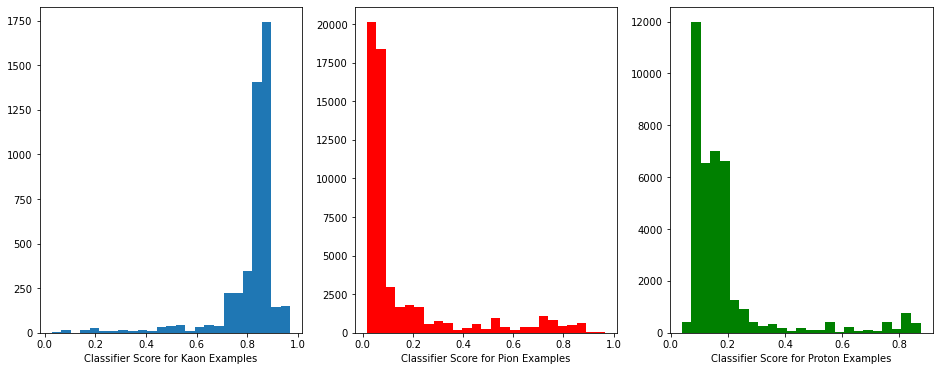

Maximum Purity:  0.9995002498750625
ROC AOC:  0.9772276705654371


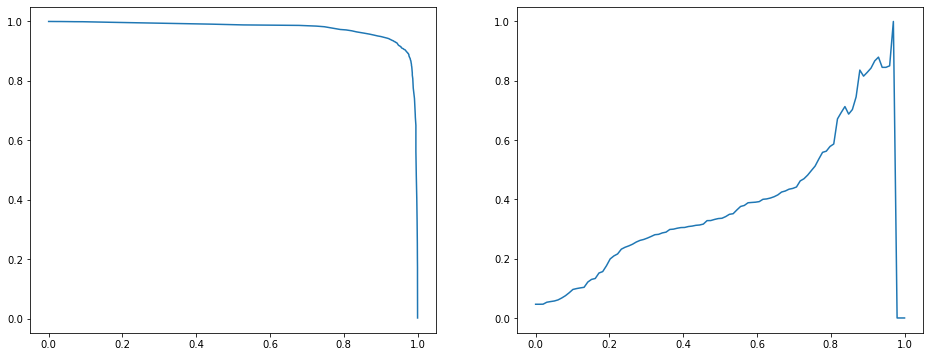

In [16]:
# scan a range of parameters for the number of estimators (ie, the number of boosting cycles)
# and the learning rate.  These are somewhat correlated, so a huge grid search isn't required.

for est in np.arange(30,31,10):
    for lr in np.arange(0.07,0.1011,0.005):
        print("Testing ", est, lr)
        bdt = GradientBoostingClassifier(random_state=1,
                                         n_estimators=est, 
                                         learning_rate=lr,
                                         max_depth=maxDepth,
                                         min_samples_split=minSS,
                                         min_samples_leaf=minSL, 
                                         max_leaf_nodes=maxLeaf)

        bdt.fit(X_train,y_train,sample_weight=sWeight)
        predictionsBinary = bdt.predict(X_test)
        print("Kaon Accuracy: ",accuracy_score(y_test[kaonIdxTest],predictionsBinary[kaonIdxTest]))

bdt = GradientBoostingClassifier(random_state=1,
                                         n_estimators=30, 
                                         learning_rate=0.09,
                                         max_depth=maxDepth,
                                         min_samples_split=minSS,
                                         min_samples_leaf=minSL, 
                                         max_leaf_nodes=maxLeaf)

bdt.fit(X_train,y_train,sample_weight=sWeight)
evalClassifier(bdt)

***
***
# Finally, make plots of the decision tree boundaries


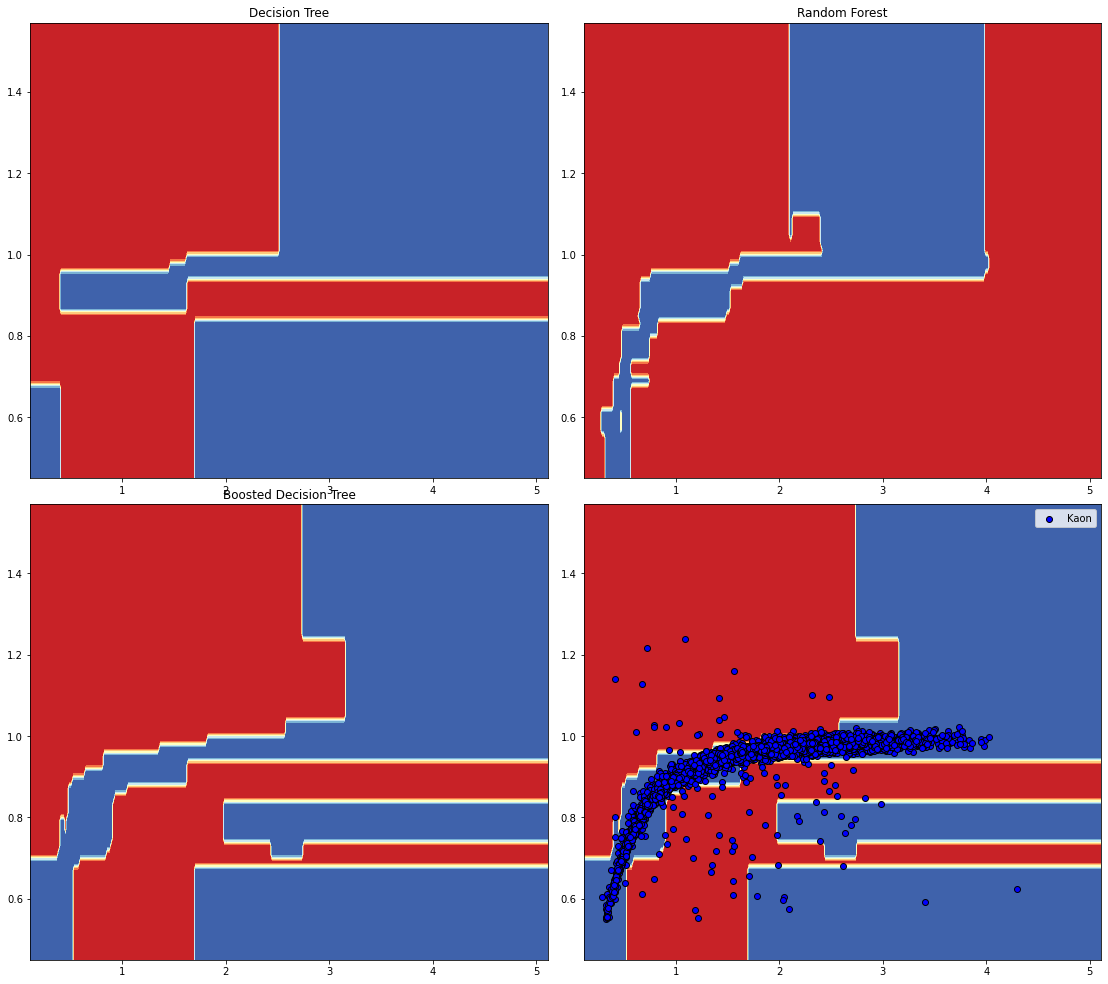

In [21]:
# Parameters
n_classes = 2
plot_colors = "ryb"
plot_step = 0.02


x_min, x_max = X_train[:, 0].min() - 0.1, X_train[:, 0].max() + 0.1
y_min, y_max = X_train[:, 1].min() - 0.1, X_train[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, plot_step),np.arange(y_min, y_max, plot_step))

fig, ax = plt.subplots(2,2,figsize=(16,14))

plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

Z = dTree.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[0,0].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
ax[0,0].set_title("Decision Tree")
Z = randForest.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[0,1].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
ax[0,1].set_title("Random Forest")
Z = bdt.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)
ax[1,0].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
ax[1,0].set_title("Boosted Decision Tree")

ax[1,1].contourf(xx, yy, Z, cmap=plt.cm.RdYlBu)
#plt.scatter(X_train[pionIdx][:,0],X_train[pionIdx][:,1],c='y',edgecolor='black',label="Pion")
ax[1,1].scatter(X_train[kaonIdx][:,0],X_train[kaonIdx][:,1],c='b',edgecolor='black',label="Kaon")
#plt.scatter(X_train[protIdx][:,0],X_train[protIdx][:,1],c='r',edgecolor='black',label="Proton")
plt.legend()